In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

# Class for handling different files

In [2]:
class  Dataset:
    #t_quantile = 3 # for 3sigma = 99,730 0204 %
    t_quantile = 2.576 # for 2.576sigma = 99% 
    knownMu = False
    
    def __init__(self, filename, co):
        self.fname = filename
        self.name = (self.fname.split('/')[-1].split('.')[0])[9:15].lower()
        self.cutoff = co
        self.n = 0
        self.Nbr = 0
        self.readFile() # "2018-11-18_01.txt"
        if "/small/" in filename:
            self.knownMu = True
            self.mu = 1.96197e-13 # just for small/FTODDUMP_MC
        elif "/large/" in filename:
            self.knownMu = True
            self.mu = 8.7593051e-13 # just for large/FTODDUMP_MC
        
    def printEntry(self, idx):
        print(np.array([self.x[idx], self.x_nbr[idx], self.mean[idx], self.var[idx], self.var_var[idx]]))
        

#### Read in file with data

In [3]:
def readFile(self):
    file  = open(self.fname, "r") 
    data = []
    x = []
    line = ""
    
    while (not line.startswith("0%") ):
        line = file.readline().rstrip("\n\r")    
        if line.startswith("nbrOfSamples"):
            self.n = int(line.split()[2])
        if line.startswith("maxi"):
            self.Nbr = int(line.split()[1])

    line += file.readline().rstrip("\n\r")
    lsplit = line.split()

    x.append(float(lsplit[0][:-2]))
    data.append([float(lsplit[2]),float(lsplit[5]),float(lsplit[7])])

    while ( lsplit[0] != "100%:"):
        line = file.readline().rstrip("\n\r")
        line += file.readline().rstrip("\n\r")
        lsplit = line.split()
        x.append(float(lsplit[0][:-2]))
        data.append([float(lsplit[2]),float(lsplit[5]),float(lsplit[7])])

    file.close()
    data = np.array(data)
    self.x = np.array(x)/100*self.n/self.Nbr
    
    reOrgData(self, data)    

#### reorganize read data

`data`-array contains `[mean, var, var_var]`  


`[x:]` --> cutting of first two values  where offset is still huge

In [4]:
def reOrgData(self, data):
    cutoff = 1

    self.mean = data[:,0]
    self.var = data[:,1]
    self.var_var = data[:,1]

    self.x = self.x[self.cutoff:]
    self.mean = self.mean[self.cutoff:]
    self.var = self.var[self.cutoff:]
    self.var_var = self.var_var[self.cutoff:]
    
    self.x_nbr = self.x*self.Nbr

#### bind functions to class

In [5]:
Dataset.readFile = readFile
Dataset.reOrgData = reOrgData

#### position of legend

In [6]:
def legendPos(c):
    return {
        'u': 'upper right',
        'l': 'lower right',
        'c': 'center right',
    }[c]

# Plots

$y_{err}$ is the standard deviation

$$y_{err} = \sqrt{\mathtt{Var}(y)} =   \sqrt { \frac { \sum _ { i = 1 } ^ { N } \left( x _ { i } - \overline { x } \right) ^ { 2 } } { N - 1 } }$$

In [7]:
def plotMean(lst, legendpos='u'):
    plotMeanlim(lst, 0, -1, legendpos)

def plotMeanlim(lst, llimit = 0.0, ulimit = -1, legendpos='u'):
    
    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)
    #print(exp)
    
    plt.figure(figsize=(10,8))
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.15,right=0.99, bottom= 0.1,top=0.98)
    
    #title = 'mean'
    #plt.title(title)
    plt.rcParams.update({'font.size': 22})
    plt.ylabel('$<E_{{MP2}}> \quad 10^{{{0}}}$'.format(exp))
    plt.xlabel('$M_i / N$')
    
    # set drawing area
    max_x = 0
    for self in lst:
        if self.x[-1] > max_x:
            max_x = self.x[-1]
    if (ulimit != -1):
        max_x = ulimit
        
    # draw grid
    plt.autoscale(enable=True, axis='y', tight=True)
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    # draw mean 
    if lst[0].knownMu:
        plt.hlines(lst[0].mu,0, max_x, linestyle = 'dashed') #, label='$\mu_0$')
    #plt.text(lst[0].mu,0,'$\mu_0$')
    
    for self in lst:
        #plt.errorbar(self.x, self.mean,  yerr = np.sqrt(self.var/self.x_nbr), fmt= 'o', capsize=4)
        if ulimit != -1:
            plt.plot(self.x[(self.x > llimit) & (self.x < ulimit)], self.mean[(self.x > llimit) & (self.x < ulimit)], marker = 'o', linestyle= 'solid', label=self.name)
        else:
            plt.plot(self.x, self.mean, marker = 'o', linestyle= 'solid', label=self.name)
    
    plt.legend(loc=legendPos(legendpos))
    labels = plt.yticks()[0]
    if lst[0].knownMu:
        plt.yticks(list(plt.yticks()[0]) + [lst[0].mu], list([round(float(label/10.0**exp), 4) for label in labels]) + ['$\mu_0$'])
    else:
        plt.yticks(list(plt.yticks()[0]), list([round(float(label/10.0**exp), 4) for label in labels]))
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(llimit, max_x)
    
    
    if ulimit != -1:
        plt.savefig('{1}/mean_lim{0}.png'.format(additional_name, directory))
    else:
        plt.savefig('{1}/mean{0}.png'.format(additional_name, directory))
    
    plt.show()
    

#plotMean(ds_, 'u')
#plotMeanlim(ds_, 0.001, 0.00391, 'u')

###  Intervallschätzung
#### für $\alpha = 0.99$

Für den Spezialfall einer Normalverteilung können wir exakte Konfidenzintervalle angeben:  
Für $\mu$, wenn $\sigma^2$ bekannt ist:
$$ \left[ \overline { X } _ { n } - z _ { \frac { 1 + \gamma } { 2 } } \sqrt { \frac { \sigma ^ { 2 } } { n } } , \overline { X } _ { n } + z _ { \frac { 1 + \gamma } { 2 } } \sqrt { \frac { \sigma ^ { 2 } } { n } } \right] $$  

<br>

Für $\mu$ wenn $\sigma^2$ unbekannt ist:
$$\left[ \overline { X } _ { n } - t _ { n - 1 ; \frac { 1 + \gamma } { 2 } } \sqrt { \frac { S _ { n } ^ { 2 } } { n } } , \overline { X } _ { n } + t _ { n - 1 ; \frac { 1 + \gamma } { 2 } } \sqrt { \frac { S _ { n } ^ { 2 } } { n } } \right]$$  
Tabelle nur bis $n = 120$, danach $n = \infty$ verwendet. [Table](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values)  
$\dfrac{1-\gamma}{2} = \dfrac{1.99}{2} = 0.995  \quad \Longrightarrow \quad t_{\infty, 0.995} = 2.576$

<br>

für $\sigma^2$:
$$\left[ \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \chi _ { n - 1 ; \frac { 1 + \gamma } { 2 } } ^ { 2 } } , \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \chi _ { n - 1 ; \frac { 1 - \gamma } { 2 } } ^ { 2 } } \right]$$



In [8]:
def func_err(x, a, b, c):
    return a / np.power(np.sqrt(x), c) + b

def test(lst, x, y, zoom, xllim = 0.0, xulim = -1, legendpos='u', inplot = True):
    exp_y = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)
    
    fig, ax = plt.subplots(figsize=[10,8])
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.125, right= 1.05, bottom= 0.1,top=0.98)
    plt.rcParams.update({'font.size': 22})
        
    # draw grid
    ax.autoscale(enable=True, axis='y', tight=True)
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    ax.set_ylabel('$<E_{{MP2}}> \quad 10^{{{0}}}$'.format(exp_y))
    ax.set_xlabel('$M_i / N$')

    if xulim == -1:
        for self in lst:
            if self.x[-1] > xulim:
                xulim = self.x[-1]
    plt.xlim(0, xulim)
    
    if inplot:
        #axins = zoomed_inset_axes(ax, zoom, loc=4,  bbox_to_anchor=(620,100)) # zoom-factor: 2.5, location: upper-left
        axins = zoomed_inset_axes(ax, zoom, loc=4) # zoom-factor: 2.5, location: upper-left
    
    if lst[0].knownMu:
        ax.hlines(lst[0].mu/(10.0**exp_y), 0, xulim, linestyle = 'dashed')
        if inplot:
            axins.hlines(lst[0].mu/(10.0**exp_y), 0, xulim, linestyle = 'dashed')
    
    #plot differen runs
    color = ['r','b', 'm', 'g', 'c', 'y', 'k', 'w']
    color_counter = 0
    
    for self in lst:
        var_deviantion = np.sqrt((self.var_var)/self.x_nbr)#*self.t_quantile
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+var_deviantion)/self.x_nbr) )
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+var_deviantion/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > xllim) & (self.x < xulim)]
        mean_red = self.mean[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        mean_deviation = mean_deviation[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        
        ax.plot(x_red,  mean_red, marker = 'o', color=color[color_counter], linestyle='solid', label=self.name)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color=color[color_counter], capsize=4, alpha = 0.4)
        
        if inplot:
            axins.plot(self.x,  self.mean, marker='o', color=color[color_counter], linestyle='solid')
            axins.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color=color[color_counter], capsize=4)
        color_counter = color_counter+1 if color_counter+1 < len(color) else 0
        
        
    if inplot:
        axins.set_xlim(*x) # apply the x-limits
        axins.set_ylim(*y) # apply the y-limits
        plt.xticks(visible=False)  # Not present ticks
        plt.yticks(visible=False)
        
        
        mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")
    
    fig.legend(loc="upper right", framealpha= 1, bbox_to_anchor=(1.32,1))

    
    y_ticks = ax.get_yticks()
    
    '''if lst[0].knownMu:
        ax.set_yticks(list(y_ticks) + [lst[0].mu], list([round(float(tick/10.0**exp_y), 4) for tick in y_ticks]) + ['$\mu_0$'])
    else:
        ax.set_yticks(list(y_ticks), list([round(float(tick/10.0**exp_y), 4) for label in y_ticks]))'''
    
    #plt.xticks(list(plt.xticks()[0]), list([round(float(tick), 4) for tick in plt.xticks()[0]]))
    #ax.autoscale(enable=True, axis='x', tight=True)
    
    
    plt.draw()
    plt.show()
    
#test(ds_[0:1], x=(0.0033, 0.0035), y=(1.93, 2.05), zoom = 4, inplot=True)

In [10]:
def func_err(x, a, b, c):
    return a / np.power(np.sqrt(x), c) + b

def MeanIntervallEst(lst, x, y, zoom, xllim = 0.0, xulim = -1, legendpos='u'):
    expsize = lst[0].t_quantile*np.sqrt((lst[0].var+np.sqrt(lst[0].var_var)/lst[0].x_nbr)/lst[0].x_nbr)[0]
    exp_y = np.floor(np.log10(np.abs(expsize))).astype(int)
    
    fig, ax = plt.subplots(figsize=[10,8])
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.125,right=0.99, bottom= 0.1,top=0.98)
    plt.rcParams.update({'font.size': 22})
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    
    ax.set_ylabel('$<E_{{MP2}}> \quad 10^{{{0}}}$'.format(exp_y))
    ax.set_xlabel('$M_i / N$')

    if xulim == -1:
        for self in lst:
            if self.x[-1] > xulim:
                xulim = self.x[-1]
    plt.xlim(0, xulim)
    
    axins = zoomed_inset_axes(ax, zoom, loc=1)
    axins.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    
    
    #color=['red', 'green', 'blue', 'cyan', 'magenta']
    color = ['r','b', 'm', 'g', 'c', 'y', 'k', 'w']
    color_counter = 0
    alpha = 0.4
    alpha_fit= 0.5
    for self in lst:
        #statistical data calculation
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > xllim) & (self.x < xulim)]
        mean_red = self.mean[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        mean_deviation = mean_deviation[(self.x > xllim) & (self.x < xulim)]/(10.0**exp_y)
        
        #plot differen runs
        ax.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', label=self.name, alpha = alpha)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], capsize=4, alpha = alpha)
                
        axins.plot(x_red, mean_red, marker = 'o', color = color[color_counter], linestyle= 'solid', label=self.name, alpha = alpha)
        axins.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', color = color[color_counter], capsize=4, alpha = alpha)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        
        ax.plot(x_red, func_err(x_red, *popt), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        ax.plot(x_red, 2*mean_red-func_err(x_red, *popt), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        axins.plot(x_red, func_err(x_red, *popt), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        axins.plot(x_red, 2*mean_red-func_err(x_red, *popt), color='gray', marker = '', linestyle= 'solid', alpha=alpha_fit)
        
        #ax.plot(x_red, lower_err(x_red, *poptl), color='gray', marker = '', linestyle= 'solid', alpha=0.7)
        
        color_counter = color_counter+1 if color_counter+1<len(color) else 0
   
        
    axins.set_xlim(*x)
    axins.set_ylim(*y) # Limit the region for zoom
       
    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)
    
    
    if lst[0].knownMu:
        print("mean known:", lst[0].mu)
        ax.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        axins.hlines(lst[0].mu/(10.0**exp_y),0, xulim, linestyle = 'dashed', color = 'black')
        
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    
    ax.legend(loc=legendPos(legendpos)) 
    plt.draw()
    plt.savefig('{1}/meanIntervallEst{0}-{2}.png'.format(additional_name, directory, len(lst)))
    plt.show()
    
    
#MeanIntervallEst(ds_[1:2], x=(0.0033, 0.0035), y=(1.8, 2.1), zoom = 14, legendpos='l')

In [12]:
'''def func_err(x, a, b, c):
    return a / np.power(np.sqrt(x), c) + b

def MeanIntervallEst(lst, legendpos='u'):
    MeanIntervallEstlim(lst, 0, -1, legendpos)

def MeanIntervallEstlim(lst, llimit = 0.0, ulimit = -1, legendpos='u'):
    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)
    
    fig, ax = plt.subplots(figsize=[10,8])
    fig.tight_layout()
    plt.gcf().subplots_adjust(left=0.125,right=0.99, bottom= 0.1,top=0.98)

    # set labels & fontsize
    title = 'mean with estimated intervall over # sampled in percent'
    #plt.title(title)
    plt.rcParams.update({'font.size': 22})
    ax.set_ylabel('$<E_{{MP2}}> \quad 10^{{{0}}}$'.format(exp))
    ax.set_xlabel('$M_i / N$')

    
    # set drawing area
    max_x = 0
    for self in lst:
        if self.x[-1] > max_x:
            max_x = self.x[-1]
    plt.xlim(0, max_x)
    if (ulimit != -1):
        max_x = ulimit
        
    # draw grid
    ax.autoscale(enable=True, axis='y', tight=True)
    ax.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    if lst[0].knownMu:
        ax.hlines(lst[0].mu,0, max_x, linestyle = 'dashed')
    
    #plt.ylim( min(min(i.mean) for i in ds) , max(max(i.mean) for i in lst) )
    #print(plt.yticks())
    
    
    for self in lst:
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        #mean_deviation = self.t_quantile*( np.sqrt(self.var/self.x_nbr) ) + ( var_deviantion )
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        #mean_deviation = ( self.t_quantile*np.sqrt((self.var+self.t_quantile*np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > llimit) & (self.x < max_x)]
        mean_red = self.mean[(self.x > llimit) & (self.x < max_x)]
        mean_deviation = mean_deviation[(self.x > llimit) & (self.x < max_x)]
        
        ax.plot(x_red, mean_red, marker = 'o', linestyle= 'solid', label=self.name)
        ax.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', capsize=4)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        print(popt, pcov)
        ax.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
        #plt.plot(x_red, (mean_red + mean_deviation), marker = 'o', linestyle= 'solid', label=self.name)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red - mean_deviation), maxfev=1000)
        print(popt, pcov)
        ax.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
    
        
    
    
    y_labels = ax.get_yticks()
    
    if lst[0].knownMu:
        ax.set_yticks(list(y_labels) + [lst[0].mu], list([round(float(label/10.0**exp), 4) for label in y_labels]) + ['$\mu_0$'])
    else:
        ax.set_yticks(list(y_labels), list([round(float(label/10.0**exp), 4) for label in y_labels]))
    
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    ax.autoscale(enable=True, axis='x', tight=True)
    
    plt.xlim(llimit, max_x)
    
    
    
    
    axins = zoomed_inset_axes(ax, 4, loc=1) # zoom-factor: 2.5, location: upper-left
    x1, x2, y1, y2 = 0.003, 0.0035, 0.1, 0.3 # specify the limits
    axins.set_xlim(x1, x2) # apply the x-limits
    axins.set_ylim(y1, y2) # apply the y-limits
    
    for self in lst:
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        #mean_deviation = self.t_quantile*( np.sqrt(self.var/self.x_nbr) ) + ( var_deviantion )
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        #mean_deviation = ( self.t_quantile*np.sqrt((self.var+self.t_quantile*np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > x1) & (self.x < x2)]
        mean_red = self.mean[(self.x > x1) & (self.x < x2)]
        mean_deviation = mean_deviation[(self.x > x1) & (self.x < x2)]
        
        axins.plot(x_red, mean_red, marker = 'o', linestyle= 'solid', label=self.name)
        axins.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', capsize=4)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        axins.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red - mean_deviation), maxfev=1000)
        axins.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
        
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    #plt.draw()
    #plt.savefig('{1}/meanIntervallEst{0}-{2}.png'.format(additional_name, directory, len(lst)))
    plt.show()


zoomed_inset_axes?
MeanIntervallEstlim(ds_[1:2])
#MeanIntervallEstlim(ds_[1:2],0.001)
#MeanIntervallEstlim(ds_)
#MeanIntervallEst(ds_[0:1])'''

'def func_err(x, a, b, c):\n    return a / np.power(np.sqrt(x), c) + b\n\ndef MeanIntervallEst(lst, legendpos=\'u\'):\n    MeanIntervallEstlim(lst, 0, -1, legendpos)\n\ndef MeanIntervallEstlim(lst, llimit = 0.0, ulimit = -1, legendpos=\'u\'):\n    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)\n    \n    fig, ax = plt.subplots(figsize=[10,8])\n    fig.tight_layout()\n    plt.gcf().subplots_adjust(left=0.125,right=0.99, bottom= 0.1,top=0.98)\n\n    # set labels & fontsize\n    title = \'mean with estimated intervall over # sampled in percent\'\n    #plt.title(title)\n    plt.rcParams.update({\'font.size\': 22})\n    ax.set_ylabel(\'$<E_{{MP2}}> \\quad 10^{{{0}}}$\'.format(exp))\n    ax.set_xlabel(\'$M_i / N$\')\n\n    \n    # set drawing area\n    max_x = 0\n    for self in lst:\n        if self.x[-1] > max_x:\n            max_x = self.x[-1]\n    plt.xlim(0, max_x)\n    if (ulimit != -1):\n        max_x = ulimit\n        \n    # draw grid\n    ax.autoscale(enable=True, axi

In [11]:
'''def func_err(x, a, b, c):
    return a / np.power(np.sqrt(x), c) + b

def MeanIntervallEst(lst, legendpos='u'):
    MeanIntervallEstlim(lst, 0, -1, legendpos)

def MeanIntervallEstlim(lst, llimit = 0.0, ulimit = -1, legendpos='u'):
    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)
    
    plt.figure(figsize=(10,8))
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.125,right=0.99, bottom= 0.1,top=0.98)

    # set labels & fontsize
    title = 'mean with estimated intervall over # sampled in percent'
    #plt.title(title)
    plt.rcParams.update({'font.size': 22})
    
    
    # set drawing area
    max_x = 0
    for self in lst:
        if self.x[-1] > max_x:
            max_x = self.x[-1]
    plt.xlim(0, max_x)
    if (ulimit != -1):
        max_x = ulimit
        
    # draw grid
    plt.autoscale(enable=True, axis='y', tight=True)
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    
    if lst[0].knownMu:
        plt.hlines(lst[0].mu,0, max_x, linestyle = 'dashed')
    
    #plt.ylim( min(min(i.mean) for i in ds) , max(max(i.mean) for i in lst) )
    #print(plt.yticks())
    
    for self in lst:
        var_deviantion = self.t_quantile*np.sqrt((self.var_var)/self.x_nbr)
        #mean_deviation = self.t_quantile*( np.sqrt(self.var/self.x_nbr) ) + ( var_deviantion )
        mean_deviation = ( self.t_quantile*np.sqrt((self.var+np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        #mean_deviation = ( self.t_quantile*np.sqrt((self.var+self.t_quantile*np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr) )
        x_red = self.x[(self.x > llimit) & (self.x < max_x)]
        mean_red = self.mean[(self.x > llimit) & (self.x < max_x)]
        mean_deviation = mean_deviation[(self.x > llimit) & (self.x < max_x)]
        
        
        plt.plot(x_red, mean_red, marker = 'o', linestyle= 'solid', label=self.name)
        plt.errorbar(x_red, mean_red,  yerr = mean_deviation, fmt= 'o', capsize=4)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red + mean_deviation), maxfev=1000)
        print(popt, pcov)
        plt.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
        #plt.plot(x_red, (mean_red + mean_deviation), marker = 'o', linestyle= 'solid', label=self.name)
        
        popt, pcov = opt.curve_fit(func_err, x_red, (mean_red - mean_deviation), maxfev=1000)
        print(popt, pcov)
        plt.plot(x_red, func_err(x_red, *popt), marker = '', linestyle= 'solid')
        
    plt.legend(loc=legendPos(legendpos))
    labels = plt.yticks()[0]
    
    if lst[0].knownMu:
        plt.yticks(list(plt.yticks()[0]) + [lst[0].mu], list([round(float(label/10.0**exp), 4) for label in labels]) + ['$\mu_0$'])
    else:
        plt.yticks(list(plt.yticks()[0]), list([round(float(label/10.0**exp), 4) for label in labels]))
    
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    
    plt.xlim(llimit, max_x)
    
    plt.savefig('{1}/meanIntervallEst{0}-{2}.png'.format(additional_name, directory, len(lst)))
    plt.show()

    
MeanIntervallEstlim(ds_[1:2])
MeanIntervallEstlim(ds_[1:2],0.001)
#MeanIntervallEstlim(ds_)
#MeanIntervallEst(ds_[0:1])'''

"def func_err(x, a, b, c):\n    return a / np.power(np.sqrt(x), c) + b\n\ndef MeanIntervallEst(lst, legendpos='u'):\n    MeanIntervallEstlim(lst, 0, -1, legendpos)\n\ndef MeanIntervallEstlim(lst, llimit = 0.0, ulimit = -1, legendpos='u'):\n    exp = np.floor(np.log10(np.abs(lst[0].mean[0]))).astype(int)\n    \n    plt.figure(figsize=(10,8))\n    plt.tight_layout()\n    plt.gcf().subplots_adjust(left=0.125,right=0.99, bottom= 0.1,top=0.98)\n\n    # set labels & fontsize\n    title = 'mean with estimated intervall over # sampled in percent'\n    #plt.title(title)\n    plt.rcParams.update({'font.size': 22})\n    \n    \n    # set drawing area\n    max_x = 0\n    for self in lst:\n        if self.x[-1] > max_x:\n            max_x = self.x[-1]\n    plt.xlim(0, max_x)\n    if (ulimit != -1):\n        max_x = ulimit\n        \n    # draw grid\n    plt.autoscale(enable=True, axis='y', tight=True)\n    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)\n    \n    if lst[0].knownMu:\n   

### Tests


Für den Mittelwert einer Normalverteilung, wenn $\sigma^2$ unbekannt ist:
$$T = \frac { \overline { X } _ { n } - \mu _ { 0 } } { \sqrt { S _ { n } ^ { 2 } / n } }$$  

$H _ { 0 } : \mu \leq \mu _ { 0 } $ gegen $ H _ { 1 } : \mu > \mu _ { 0 } : $ verwerfen, wenn $ T > t _ { n - 1 ; 1 - \alpha }$  
$H _ { 0 } : \mu \geq \mu _ { 0 } $ gegen $ H _ { 1 } : \mu < \mu _ { 0 } : $ verwerfen, wenn $ T < - t _ { n - 1 ; 1 - \alpha }$  
$H _ { 0 } : \mu = \mu _ { 0 } $ gegen $ H _ { 1 } : \mu \neq \mu _ { 0 } : $ verwerfen, wenn $ | T | > t _ { n - 1 ; 1 - \alpha / 2 }$

<br><br>  

Für die Varianz einer Normalverteilung:
$$T = \frac { ( n - 1 ) S _ { n } ^ { 2 } } { \sigma _ { 0 } ^ { 2 } }$$

$H _ { 0 } : \sigma ^ { 2 } \geq \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } < \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T < \chi _ { n - 1 ; \alpha } ^ { 2 }$  
$H _ { 0 } : \sigma ^ { 2 } = \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } \neq \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T > \chi _ { n - 1 ; 1 - \alpha / 2 } ^ { 2 } $ oder $ T < \chi _ { n - 1 ; \alpha / 2 } ^ { 2 }$  
$H _ { 0 } : \sigma ^ { 2 } \leq \sigma _ { 0 } ^ { 2 } $ gegen $ H _ { 1 } : \sigma ^ { 2 } > \sigma _ { 0 } ^ { 2 } : $ verwerfen, wenn $ T > \chi _ { n - 1 ; 1 - \alpha } ^ { 2 }$

In [13]:
def MeanTest(lst, legendpos='u'):
    
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 22})
    plt.ylabel('$T$')
    plt.xlabel('$M_i / N$')
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.23,right=0.99, bottom= 0.1,top=0.98)
    # set drawing area
    maxx = 0
    for self in lst:
        if self.x[-1] > maxx:
            maxx = self.x[-1]
    
        
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.hlines(lst[0].t_quantile, 0, maxx, linestyle = 'dashed')
    plt.hlines(-lst[0].t_quantile, 0, maxx, linestyle = 'dashed')
    
    
    #plt.yticks(list(plt.yticks()) + [lst[0].t_quantile, -lst[0].t_quantile])    
    #print(plt.yticks())
    
    for self in lst:
        T = (self.mean-self.mu)/np.sqrt((self.var)/self.x_nbr)
        #T = (self.mean-self.mu)/(np.sqrt((self.var + np.sqrt(self.var_var)/self.x_nbr)/self.x_nbr))
        plt.plot(self.x, T, marker = 'o', linestyle= 'solid', label=self.name)
    
    plt.legend(loc=legendPos(legendpos))
    labels = plt.yticks()[0]
    plt.yticks(list(plt.yticks()[0]) + [lst[0].t_quantile] + [ -lst[0].t_quantile], list([round(float(label), 4) for label in labels]) + ['$t_{n-1;1-\\alpha/2}$', '$-t_{n-1;1-\\alpha/2}$'])
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(0,  maxx)
    
    plt.savefig('{1}/t-Test{0}-{2}.png'.format(additional_name,directory,len(lst)))
    plt.show()
    
#MeanTest(ds_)

In [14]:
def plot_var(lst, llimit = 0.0, ulimit = -1, legendpos='u'):
    exp = np.floor(np.log10(np.abs(lst[0].var[-1]))).astype(int)
    print(np.sqrt(lst[0].var[-1]))
    
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 22})
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.115,right=0.98, bottom= 0.1,top=0.98)
    #plt.title('var over # sampled ')
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.ylabel('$S^2 \quad 10^{{{0}}}$'.format(exp))
    plt.xlabel('$M_i / N$')
        
     # set drawing area
    maxx = 0
    for self in lst:
        if self.x[-1] > maxx:
            maxx = self.x[-1]
    plt.xlim(0, maxx)
    if (ulimit != -1):
        plt.xlim(llimit, ulimit)    
    
    #plt.yticks(list(plt.yticks()) + [lst[0].t_quantile, -lst[0].t_quantile])    
    #print(plt.yticks())
    
    for self in lst:
        #plt.errorbar(self.x, self.var,  yerr = self.t_quantile*np.sqrt(self.var_var/self.x_nbr), fmt= 'o', capsize=4)
        if ulimit != -1:
            plt.plot(self.x[(self.x > llimit) & (self.x < ulimit)], self.var[(self.x > llimit) & (self.x < ulimit)], marker = 'o', linestyle= 'solid', label=self.name)
        else:
            plt.plot(self.x, self.var, marker = 'o', linestyle= 'solid', label=self.name)
        
    plt.yscale('log')
    plt.legend(loc=legendPos(legendpos))
    ylabels = plt.yticks()[0]
    plt.yticks(ylabels, list([round(float(ylabel/10.0**exp), 4) for ylabel in ylabels]) )
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    
    
    plt.savefig('{1}/variance{0}-{2}.png'.format(additional_name, directory, len(lst)))
    plt.show()
    
#plot_var(ds_, 'c')

In [15]:
def plot_fitConfi(self, legendpos='u'):
    exp = np.floor(np.log10(np.abs(self.var[-1]))).astype(int)
    
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 22})
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.115,right=0.98, bottom= 0.1,top=0.98)
    #plt.title('var over # sampled ')
    plt.grid(color='lightgray', linestyle='--', linewidth=0.7)
    plt.ylabel('$S^2 \quad 10^{{{0}}}$'.format(exp))
    plt.xlabel('$M_i / N$')
        
    
    #plt.errorbar(self.x, self.var,  yerr = self.t_quantile*np.sqrt(self.var_var/self.x_nbr), fmt= 'o', capsize=4)
    plt.plot(self.x, self.var, marker = 'o', linestyle= 'solid', label=self.name)
    
    plt.legend(loc=legendPos(legendpos))
    
    ylabels = plt.yticks()[0]
    plt.yticks(ylabels, list([round(float(ylabel/10.0**exp), 4) for ylabel in ylabels]) )
    plt.xticks(list(plt.xticks()[0]), list([round(float(xlabel), 4) for xlabel in plt.xticks()[0]]))
    plt.autoscale(enable=True, axis='x', tight=True)
    
    
    plt.savefig('{1}/fitVar{0}-{2}.png'.format(additional_name, directory, len(lst)))
    plt.show()
    
#plot_var(ds_, 'c')

### Sampling Order & Datafile reducer for more visability

In [16]:
def getSampleTypes(flist, types):
    if len(types) == 0:
        return flist
    flist = np.array(flist)
    sampleType = [s.split('_')[1] for s in flist]
    sampleType = np.array(sampleType)
    fname = flist[np.isin(sampleType, types)]
    return fname

def getSampleDates(flist, dates):
    if len(dates) == 0:
        return flist
    flist = np.array(flist)
    sampleType = [s.split('_')[0] for s in flist]
    sampleType = np.array(sampleType)
    fname = flist[np.isin(sampleType, dates)]
    return fname

# Main

In [17]:
print('List of all data-files:')
folder = "./data/small/"
#folder = "./data/large/"

flist = os.listdir(folder)
print(np.array(flist))

print('\nTypes to choose from:')
samplingType = np.unique([s.split('_')[1] for s in flist])
print(samplingType)

List of all data-files:
['18-02-13_ttuccc_02.txt' '18-02-14_ttuccc_03.txt'
 '18-02-05_uccucc_01.txt' '18-02-14_ttuccc_01.txt'
 '19-05-26_ttuccc_01.txt' '19-05-21_uccucc_02.txt'
 '18-02-13_ttuccc_01.txt' '18-02-05_uccucc_02.txt'
 '18-02-05_ucctuu_01.txt' '18-02-14_ttuccc_02.txt'
 '19-05-21_ttTccc_02.txt' '18-02-13_ttuccc_03.txt'
 '19-05-26_ttuccc_02.txt' '19-05-26_cutccc_03.txt'
 '18-02-08_cutccc_01.txt' '18-02-14_ttuccc_05.txt'
 '19-05-20_ttTccc_03.txt' '19-05-26_ttuccc_03.txt'
 '18-02-05_cutccc_01.txt' '19-05-21_uccucc_03.txt'
 '18-02-20_ttuccc_02.txt' '19-05-26_cutccc_02.txt'
 '19-05-21_uccucc_01.txt' '19-05-26_cutccc_01.txt'
 '18-02-06_cutccc_01.txt' '18-02-05_cutccc_02.txt'
 '18-02-20_ttuccc_01.txt' '18-02-05_ucctuu_02.txt'
 '18-02-08_uuuuuu_01.txt' '19-05-21_ttTccc_01.txt'
 '19-05-20_ttTccc_01.txt' '18-02-14_ttuccc_06.txt'
 '18-02-20_cutccc_01.txt' '19-05-20_ttTccc_02.txt'
 '18-02-20_cutccc_02.txt' '18-02-05_ucctuu_03.txt'
 '18-02-14_ttuccc_04.txt' '18-02-08_uuuuuu_02.txt']

Types

In [15]:
samplingTyp_list = ['uccucc'] # ['ttTccc', 'uccucc', 'uuuuuu','ttuccc']
#samplingTyp_list = ['ttTccc']
samplingTyp_list = ['uccucc', 'ttTccc'] 
#samplingTyp_list = ['uccucc', 'ttTccc', 'cutccc', 'ttuccc', 'ucctuu'] 

#samplingTyp_list = ['uccccc', 'ccTccc'] 

additional_name = '-'+'-'.join(str(s) for s in samplingTyp_list)

directory = './graphs/{0}'.format(folder[7:-1])
if not os.path.exists(directory):
    os.makedirs(directory)
directory += '/{0}'.format(additional_name[1:])
if not os.path.exists(directory):
    os.makedirs(directory)

flist_red = getSampleDates(getSampleTypes(flist, samplingTyp_list), [])

print('--------------------', flist_red.shape[0], 'files --------------------')
print(flist_red)
print('\nfolder:', directory, 'exists {0}'.format(os.path.exists(directory)), '---', 'nameaddition:', additional_name)

-------------------- 10 files --------------------
['18-02-05_uccucc_01.txt' '19-05-21_uccucc_02.txt'
 '18-02-05_uccucc_02.txt' '19-05-21_ttTccc_02.txt'
 '19-05-20_ttTccc_03.txt' '19-05-21_uccucc_03.txt'
 '19-05-21_uccucc_01.txt' '19-05-21_ttTccc_01.txt'
 '19-05-20_ttTccc_01.txt' '19-05-20_ttTccc_02.txt']

folder: ./graphs/small/uccucc-ttTccc exists True --- nameaddition: -uccucc-ttTccc


In [16]:
fname = [folder + file for file in flist_red]
Dset = [Dataset(i, 1) for i in fname]

nbrEntriesOfDsets = [Dset[i].n for i in range(len(Dset))]
nbrEntriesOfDsets = np.array(nbrEntriesOfDsets)

if not np.all(nbrEntriesOfDsets == nbrEntriesOfDsets[0]):
    print("\nNOT ALL DATASETS HAVE THE SAME ENTRY NUMBER  ==> splitUp!\n")

Dset = np.array(Dset)
splitDs = [Dset[nbrEntriesOfDsets == i] for i in np.unique(nbrEntriesOfDsets)]

for j in range(len(splitDs)):
    print(str(j) + ": ", '#' + str(len(splitDs[j])), splitDs[j][0].n, splitDs[j][0].n/splitDs[j][0].Nbr,
          [i.fname.split('/')[-1].split(".")[0].split('_')[1] for i in splitDs[j]])


NOT ALL DATASETS HAVE THE SAME ENTRY NUMBER  ==> splitUp!

0:  #2 291999744 0.0009765625 ['uccucc', 'uccucc']
1:  #8 1167998976 0.00390625 ['uccucc', 'ttTccc', 'ttTccc', 'uccucc', 'uccucc', 'ttTccc', 'ttTccc', 'ttTccc']


In [149]:
############# select files with number of samples #############
ds = np.hstack(splitDs[:])
ds = np.hstack(splitDs[1]) #uccucc
#ds = np.append(ds, np.hstack(splitDs[0]))

#print(ds.shape[0], [i.fname[22:-7] for i in ds])

ds_= ds
#ds_ = np.delete(ds, [0,3]) #tttccc
ds_ = np.delete(ds, [1,6]) #uccc-tttccc
#ds_ = ds[[1,2,4,5,7,10]] #'uccucc', 'ttTccc', 'cutccc', 'ttuccc', 'ucctuu'
#print(ds_.shape[0], [i.fname[22:-7] for i in ds_])

In [150]:
mean_r = []
var_r = []
    
for self in ds_:
    mean_r.append(self.mean[-1])
    var_r.append(self.var[-1])
        
mean_r = np.array(mean_r)
var_r = np.array(var_r)

#tabel = np.vstack( (np.array(mean_r.append(0*np.mean(mean_r)), np.array([var_r,0*np.mean(var_r)]))))
if ds_[0].knownMu:
    tabel = np.vstack(( np.full(np.hstack((mean_r, np.mean(mean_r))).shape, ds_[0].mu), \
                        np.hstack((mean_r, np.mean(mean_r))), \
                        np.hstack((mean_r, np.mean(mean_r))) - ds_[0].mu, \
                        np.hstack((var_r, np.mean(var_r))), \
                        ds_[0].t_quantile*np.sqrt(np.hstack((var_r, np.mean(var_r))) / ds_[0].x_nbr[-1]) \
                      )).T

    #tabel = np.hstack((tabel,))
    print(tabel)



#print(np.mean(mean_r) - ds_[0].mu, mean_r - ds_[0].mu)

[[ 1.96197000e-13  1.97727000e-13  1.53000000e-15  3.18328000e-21
   4.25267357e-15]
 [ 1.96197000e-13  1.96186000e-13 -1.10000000e-17  9.68273000e-23
   7.41691904e-16]
 [ 1.96197000e-13  1.96547000e-13  3.50000000e-16  3.14997000e-21
   4.23036496e-15]
 [ 1.96197000e-13  1.97326000e-13  1.12900000e-15  3.18890000e-21
   4.25642591e-15]
 [ 1.96197000e-13  1.96107000e-13 -9.00000000e-17  9.65759000e-23
   7.40728423e-16]
 [ 1.96197000e-13  1.96233000e-13  3.60000000e-17  9.65554000e-23
   7.40649802e-16]
 [ 1.96197000e-13  1.96687667e-13  4.90666667e-16  1.63535143e-21
   3.04810677e-15]]


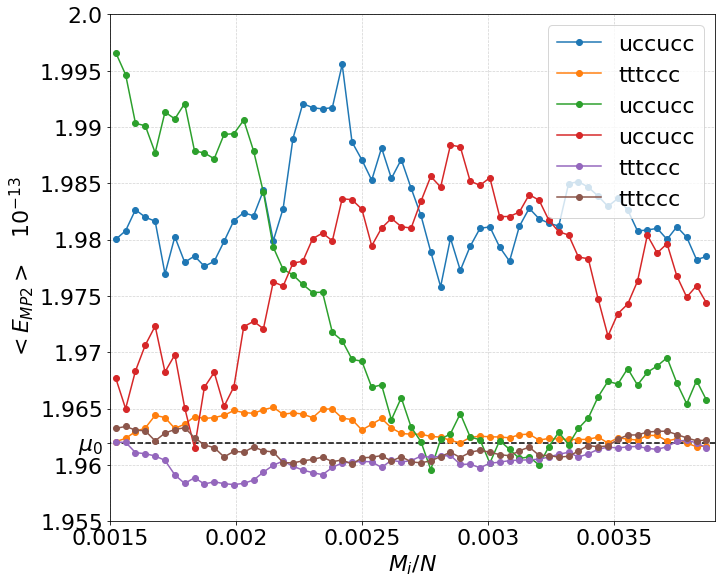

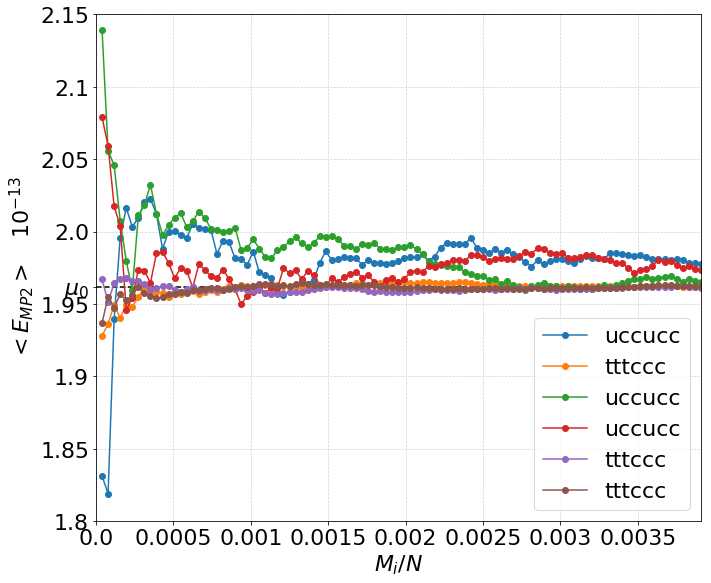

mean known: 1.96197e-13


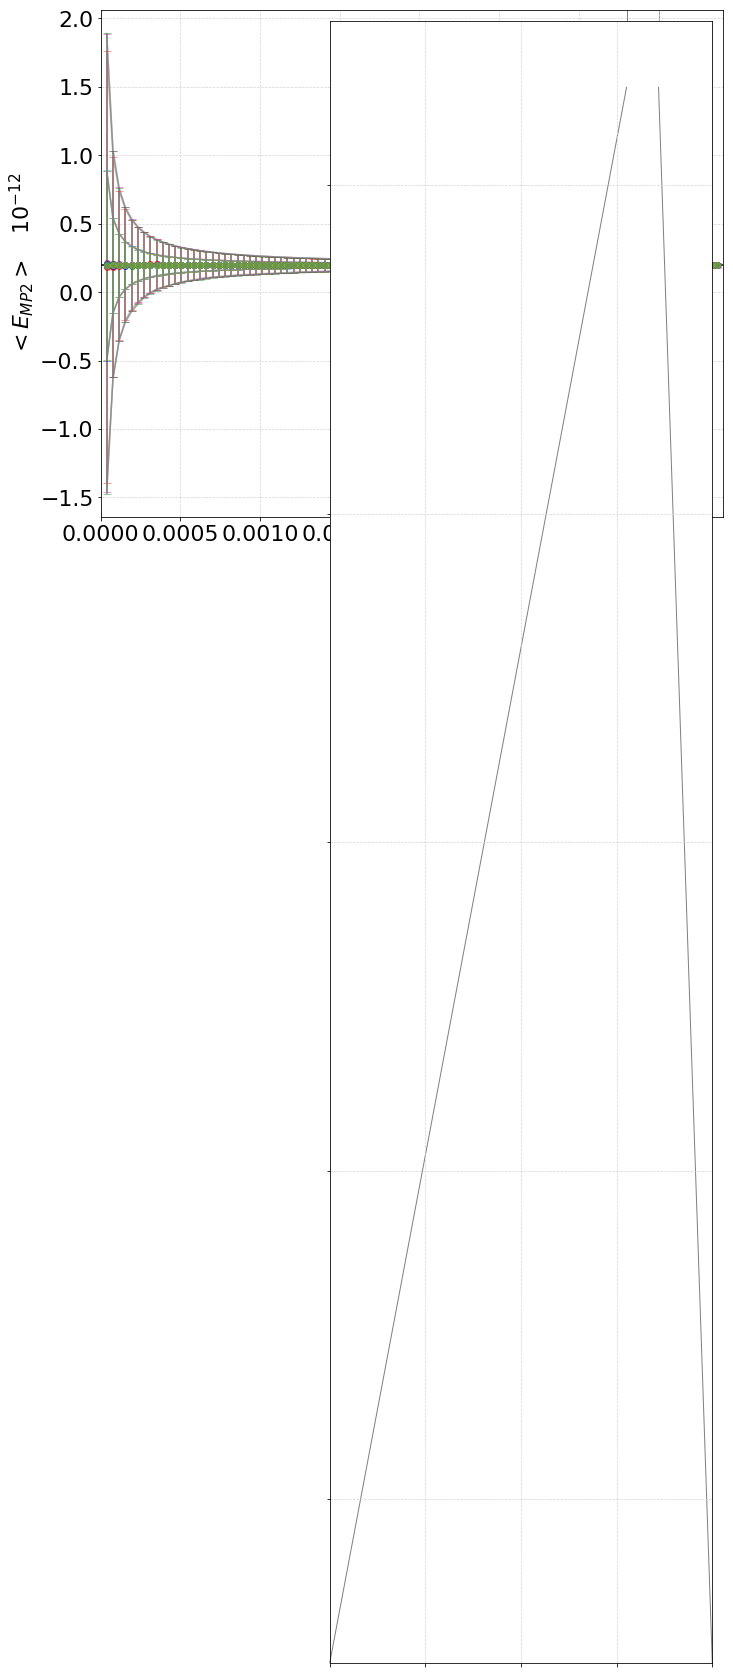

NameError: name 'MeanIntervallEstlim' is not defined

In [151]:
plotMeanlim(ds_, 0.0015, 0.0039, 'u')
#plotMeanlim(ds_[[-1,-2,3,5,9,10]], 0.0015, 0.0039)
plotMean(ds_, 'l')

MeanIntervallEst(ds_[:])
MeanIntervallEstlim(ds_[:],0.001, 0.0035)
#MeanIntervallEst(ds_[[-2]])


#MeanTest(ds_,'l')

plot_var(ds_,'c')
#plot_var(ds_[[1,2,3,5]],'c')
#plot_var(ds_[8:],'c')